In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib import cm
from SolarTypeDistribution import Distribution
from ReadFile import Read
from matplotlib.colors import LogNorm
from CenterOfMass1 import CenterOfMass1
from CenterOfMass import CenterOfMass
from GalaxyMass import ComponentsMass
import astropy.units as u
import astropy.constants as const

In [2]:
t,n,M31 = Read('./snapshots/M31_800.txt')
dis = Distribution('./snapshots/M31')
mask = dis.Mask(8)

In [57]:
COM = CenterOfMass('./snapshots/M31_800.txt',2)
compos = COM.COM_P(0.1,4).value
comvel = COM.COM_V(compos[0],compos[1],compos[2]).value
x = M31['x'][mask] - compos[0]
y = M31['y'][mask] - compos[1]
z = M31['z'][mask] - compos[2]
rnew = np.sqrt(x**2+y**2+z**2)
vx = M31['vx'][mask] - comvel[0]
vy = M31['vy'][mask] - comvel[1]
vz = M31['vz'][mask] - comvel[2]
velnew = np.sqrt(vx**2+vy**2+vz**2)

In [58]:
t,n,M31start = Read('./snapshots/M31_000.txt')

In [59]:
COMstart = CenterOfMass('./snapshots/M31_000.txt',2)
comstartpos = COMstart.COM_P(0.1,4).value
comstartvel = COMstart.COM_V(comstartpos[0],comstartpos[1],comstartpos[2]).value
xstart = M31start['x'][mask] - comstartpos[0]
ystart = M31start['y'][mask] - comstartpos[1]
zstart = M31start['z'][mask] - comstartpos[2]
r = np.sqrt(xstart**2+ystart**2+zstart**2)
vxstart = M31start['vx'][mask] - comstartvel[0]
vystart = M31start['vy'][mask] - comstartvel[1]
vzstart = M31start['vz'][mask] - comstartvel[2]
vel = np.sqrt(vxstart**2+vystart**2+vzstart**2)

In [60]:
radiiratio = rnew/r
velratio = velnew/vel

In [61]:
rlarger = np.where(radiiratio > 1)
rsmaller = np.where(radiiratio < 1)
vlarger = np.where(velratio > 1)
vsmaller = np.where(velratio < 1)

In [62]:
print("The percentage of particles with final radii greater than their initial radii is", np.around(100 * len(radiiratio[rlarger])/len(radiiratio),2))
print("The percentage of particles with final velocities greater than their initial velocities is", np.around(100 * len(velratio[vlarger])/len(velratio),2))

The percentage of particles with final radii greater than their initial radii is 62.62
The percentage of particles with final velocities greater than their initial velocities is 49.18


# Plotting the final outcomes

Text(1.24032,0.802619,'Mean: 1.13')

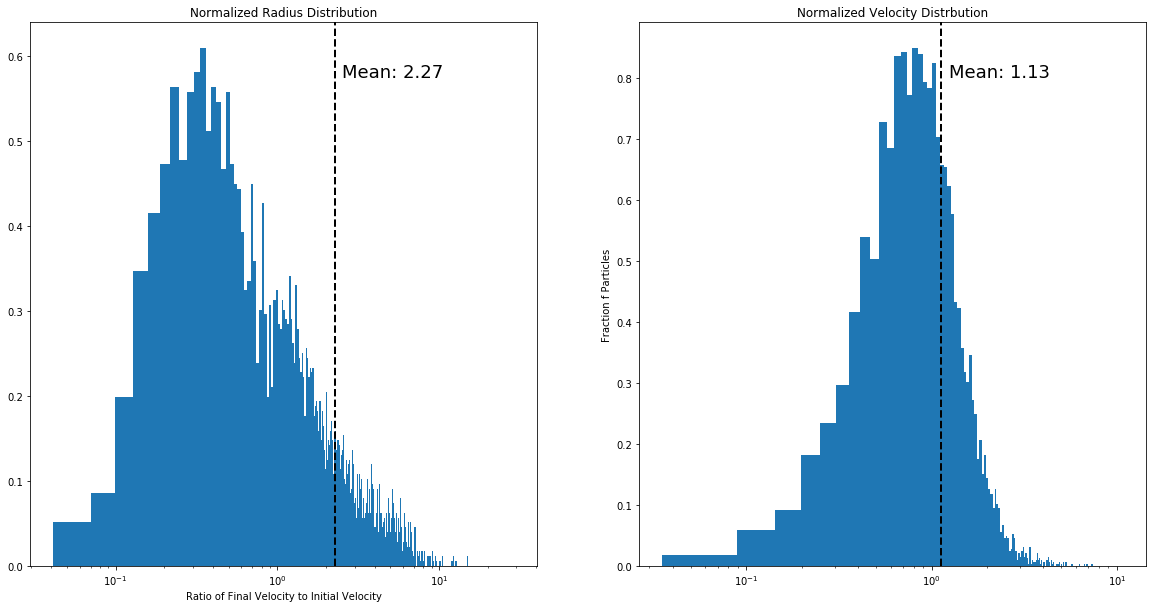

In [63]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.hist(radiiratio,bins=1000,density=True)
ax2.hist(velratio,bins=200,density=True)
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_title('Normalized Radius Distribution')
ax2.set_title('Normalized Velocity Distrbution')
ax1.set_xlabel('Ratio of Final Radius to Initial Radius')
ax1.set_xlabel('Ratio of Final Velocity to Initial Velocity')
ax2.set_ylabel('Fraction of Particles')
ax2.set_ylabel('Fraction f Particles')
ax1.axvline(radiiratio.mean(), color='k', linestyle='dashed', linewidth=2)
ax2.axvline(velratio.mean(), color='k', linestyle='dashed', linewidth=2)
a,b = ax1.get_ylim()
c,d = ax2.get_ylim()
ax1.text(radiiratio.mean()*1.1, b*0.9, 'Mean: {:.2f}'.format(radiiratio.mean()),fontsize=18)
ax2.text(velratio.mean()*1.1, d*0.9, 'Mean: {:.2f}'.format(velratio.mean()),fontsize=18)

In [15]:
M31particles = M31[mask]
M31disk = M31[np.where(M31['type'] == 2)]

(-50, 125)

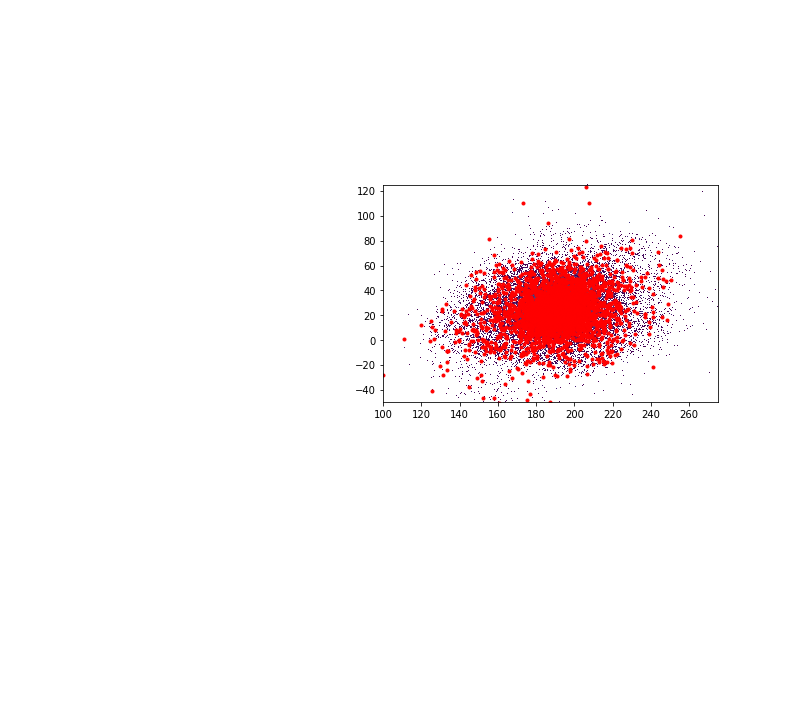

In [16]:
plt.hist2d(M31disk['x'],M31disk['y'],bins=(1000,1000),norm=LogNorm())
plt.plot(M31particles['x'][rlarger],M31particles['y'][rlarger],'r.')
plt.xlim(100,275)
plt.ylim(-50,125)

# Rotate the frame and plot projections

In [17]:
# a function that will rotate the position and velocity vectors
# so that the disk angular momentum is aligned with z axis. 

def RotateFrame(posI,velI):
    # input:  3D array of positions and velocities
    # returns: 3D array of rotated positions and velocities such that j is in z direction

    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel

In [18]:
pos = np.transpose(np.array([x,y,z]))
vel = np.transpose(np.array([vx,vy,vz]))
posstart = np.transpose(np.array([xstart,ystart,zstart]))
velstart = np.transpose(np.array([vxstart,vystart,vzstart]))

In [19]:
pos1,vel1 = RotateFrame(posstart,velstart)
pos2,vel2 = RotateFrame(pos,vel)

Text(0,0.5,'Y (kpc)')

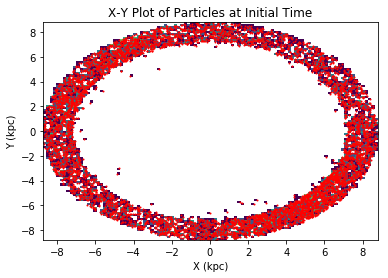

In [90]:
plt.hist2d(pos1[:,0],pos1[:,1],bins=100,norm=LogNorm())
plt.plot(pos1[:,0],pos1[:,1],'r.',ms=2)
plt.title('X-Y Plot of Particles at Initial Time')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')

Text(0,0.5,'Y (kpc)')

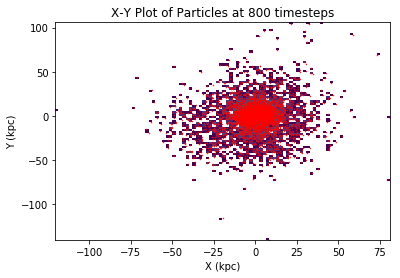

In [89]:

plt.hist2d(pos2[:,0],pos2[:,1],bins=100,norm=LogNorm())
plt.plot(pos2[:,0],pos2[:,1],'r.',ms=1)
plt.title('X-Y Plot of Particles at 800 timesteps')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')

# Code from previous attempt I'm not willing to throw away yet

In [3]:
t,n,MW = Read('./snapshots/MW_800.txt')
t,n,M33 = Read('./snapshots/M33_000.txt')

## Tried to find this for Justin because np.concatenate doesn't really work
Merger = np.hstack((M31,MW))  
Mergermask = np.where(Merger['type'] == 1)

In [5]:
np.savetxt('Merger_800.txt',Merger,header='type m x y z vx vy vz',comments='#',fmt=['%.6f','%.6f','%.6f','%.6f','%.6f','%.6f','%.6f','%.6f'])

In [6]:
# This function calculates the potential of a particle due to the parts of  a
# galaxy that can be modeled as a Hernquist sphere (i.e. the bulge and halo)
def HernquistPotential(M,r_a,x,y,z):
    # M is the mass of either the halo or bulge of the galaxy
    # r_a is the scale radius of the bulge or halo
    # x,y,z are the current position of the particle in the galaxy's frame
    
    # r is the magnitude of the separation
    r = np.sqrt(x**2 + y**2 + z**2) * u.kpc
    
    # Calculate potential      >>>>       Hernquist 1990, ApJ...356..359H
    potential = const.G.to(u.kpc**3 / u.Msun / u.s**2) * M * u.Msun / (r + r_a)
    
    # Returns the scalar potential
    return potential.to(u.km**2 / u.s**2)

In [7]:
# Determines the escape velocity of a particle at a given radius
# If velocity is below this, it is bound. 
# Could be refined to take only near circular orbits
def VBound():
    # pos is a 2-D array of particle relative position information
    
    # Vesc = sqrt(2*potential) and the potential is position dependent
    
    Vesc = np.sqrt(2*potential)
    
    # Returns an array with a length equal to the input array
    return Vesc

In [9]:
r_a = 52 * u.kpc
Mhalo = (ComponentsMass('./snapshots/M31_800.txt',1).value + ComponentsMass('./snapshots/MW_800.txt',1).value) * 1e12
potential = HernquistPotential(Mhalo,r_a,x,y,z).value

In [ ]:
def histogram(i):
    
    snapshot = str(i).zfill(3)
    file1 = './snapshots/M31_' + snapshot + '.txt'
    file2 = './snapshots/M33_' + snapshot + '.txt'
    file3 = './snapshots/MW_' + snapshot + '.txt'
    a,b,data1 = Read(file1)
    a,b,data2 = Read(file2)
    a,b,data3 = Read(file3)
    LGnow = np.hstack((data1,data2,data3))
    LGnow = LGnow[LGmask]
    
    plt.xlim(-500,400)
    plt.ylim(-150,650)
    plt.hist2d(LGnow['x'],LGnow['z'],bins=[1050,1050],norm=LogNorm())
    plt.plot(data1['x'][mask],data1['z'][mask],'r.')
    

In [ ]:
fig, ax = plt.subplots()
plt.hist2d(M31['x'][M31mask],M31['z'][M31mask],bins=[1050,1050],norm=LogNorm())
plt.plot(M31['x'][mask],M31['z'][mask],'r.')
plt.xlim(-450,-300)
plt.ylim(-400,-200)
plt.colorbar()

In [ ]:
fig, ax = plt.subplots()
histogram(800)
plt.xlim(0,350)
plt.ylim(-100,450)
plt.colorbar()